<a href="https://colab.research.google.com/github/brianMutea/Spam-Classification-with-TensorFlow-Keras-NLTK-and-Comet/blob/main/Includes%20Kangas%20Email_Spam_Classifier_with_TensorFlow%2C_Keras_and_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps:

* Glabbing a dataset
* EDA
* Tokenization
* Removing stowords, punctuation and setting text to lowercase(casefold() or lower())
* Stemming/Lemmatization(preferred)
* Vectorizing the text(BoW or TfidfVectorizer(choice)) 
  * [Check the difference](https://github.com/brianMutea/Bag-of-Words-and-TfidfVectorizer)
* Creating and Training the model
* Model evaluation

**Note:** For this task we will integrate with Comet Ml platform


## Comet ML 

To enable comet to track our entire expereiment we will wirte the follwing code below:

In [101]:
# if comet_ml not installed in environment, install

%pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import comet_ml

experiment = comet_ml.Experiment(
    api_key="XG22Dn8g5Yq4srM9rLFHa39JY", #Use your api_key from your comet_profile
    project_name="Email Spam Classifier", 
    log_code=True,
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/b-capt/email-spam-classifier/f9fb44eec56b4dd88df7d13dda90b66e



**Importing all the required libraries and modules...**

In [103]:
# for data
import numpy as np
import pandas as pd

# for visuals
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# from nltk for NLP
import nltk
import string # for use in punctuation removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# text preprocessing from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# for the NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# The dataset

**Download the dataset:**
* https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

## Reading the data and EDA with Kangas

In [104]:
# import kangas

%pip install kangas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import kangas as kg

# Read the data using Kangas
dg = kg.DataGrid.read_csv("spam_data.csv")

Loading CSV file 'spam_data.csv'...


5573it [00:00, 92952.12it/s]
100%|██████████| 5572/5572 [00:00<00:00, 19403.13it/s]


In [106]:
dg.get_columns()

['label', 'message']

In [107]:
dg.head(10)

In [108]:
dg.tail(10)

In [109]:
#Fire the Kangas UI

dg.show()

Saving data...


100%|██████████| 5572/5572 [00:00<00:00, 130593.00it/s]


Saving datagrid to 'spam_data.datagrid'...
Extending data...


100%|██████████| 5572/5572 [00:00<00:00, 41885.08it/s]


Computing statistics...


100%|██████████| 3/3 [00:00<00:00, 216.54it/s]


<IPython.core.display.Javascript object>

In [110]:
dg.select_count("{'label'} == 'ham' ")

4825

In [111]:
dg.get_schema()

{'row-id': {'field_name': 'column_0', 'type': 'ROW_ID'},
 'label': {'field_name': 'column_1', 'type': 'TEXT'},
 'message': {'field_name': 'column_2', 'type': 'TEXT'}}

## Reading the data and EDA with Pandas

### Loading the dataset

In [112]:
# with pandas

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

In [113]:
rows, columns = df.shape

print(f"Dataset has {rows} rows and {columns} columns.")

Dataset has 5572 rows and 2 columns.


In [114]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [115]:
# Check for missing values

df.isnull().sum()

label      0
message    0
dtype: int64

Also check if there are empty strings in the dataset

This is because for databases, when a cell has no info, an empty string is used in place

In [116]:
blanks = []
for iter, label, msg in df.itertuples(name="Ham_spam"):
  if msg.isspace():
    blanks.append(1)

In [117]:
# print the blanks array
blanks

[]

We have no empty strings...

Let's Check the **distribution of each label in the label column**

In [118]:
plt.rcParams.update({'font.size': 14})

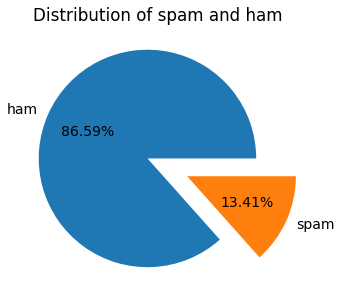

In [119]:
category_count = df['label'].value_counts()

fig , ax = plt.subplots(figsize=(20, 5))
explode = [0.1, 0.3]
ax.pie(category_count, labels=category_count.index, explode=explode, autopct='%1.2f%%')
ax.set_title('Distribution of spam and ham')
plt.show()

### Hang on...

In the following section we willl define a function that will do the following:
* Tokenize the message
* Remove the stopwords, punctuation and convert all text to lowercase
* Lemmatize the token
* convert the data into vectors with TfidfVecotrizer for better performance of our model.

In [120]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [121]:
import re

def preprocess_mesg(message):

  preprocessed_msg = []
  # first lets convert the senetence into lower case
  message_lower = message.lower()
  message = re.sub(r'[^a-zA-Z0-9\s]', ' ', message_lower)

  # Remove stopwords, and punctuation
  stopword_and_punctiation = set(stopwords.words('english') + list(string.punctuation))

  message = word_tokenize(message)

  lemmatizer = WordNetLemmatizer()

  cleaned_message = [preprocessed_msg.append(lemmatizer.lemmatize(word)) for word in message if word not in stopword_and_punctiation]
  cleaned_message = " ".join(preprocessed_msg)
  
  return cleaned_message

df['message'] = df['message'].apply(preprocess_mesg)

In [122]:
df.head()

,label,message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


In [123]:
df['message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    2nd time tried 2 contact u u 750 pound prize 2...
5568                            b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: message, Length: 5572, dtype: object

Get the **Predictor and target variables**

In [124]:
messages = df['message'].values # X
labels = df['label'].values # y

In [125]:
messages.shape, labels.shape

((5572,), (5572,))

Let's convert the labels into numerical values with Keras one-hot encoding

We will use the `to_categorical()` method of the Keras API to do that.

This is a easier replacement of using `get_dummies` or one hot encoding in sklearn

In [126]:
from keras.utils import to_categorical

label2int = {'ham': 1, 'spam':0}
labels = [label2int[label] for label in labels]
labels = to_categorical(labels)

In [127]:
labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Now we scale our training data

In [128]:
X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.30, random_state=42)

In [129]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3900,), (1672,), (3900, 2), (1672, 2))

We split first and vectorize later as this prevents data leakage in our training set

## Feature extraction with TfidfVectorizer

Next let's apply the TfidfVectorizer to convert the data into a normalized form

Performes better than the CounterVectorizer since it take into consideration the importance of a word thus most time weighs less important words less

In [130]:
tfidfV = TfidfVectorizer()

X_train_tfidfV = tfidfV.fit_transform(X_train).toarray()
X_test_tfidfV = tfidfV.transform(X_test).toarray()

In [131]:
X_train_tfidfV.shape, X_test_tfidfV.shape

((3900, 6601), (1672, 6601))

In [132]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# scaled_X_train = scaler.fit_transform(X_train_tfidfV)
# scaled_X_test = scaler.transform(X_test_tfidfV)

In [133]:
X_train_tfidfV[30:50]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [134]:
X_train_tfidfV.shape[1]

6601

In [135]:
X_test_tfidfV.shape[1]

6601

Next we create a Keras sequential model using the input dimension equal to the size of the vectorized sentences.

In [136]:
model = Sequential()

input_dim = X_train_tfidfV.shape[1]

model.add(Dense(8, input_dim=input_dim, activation='relu'))
model.add(Dense(8, input_dim=input_dim, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [137]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 52816     
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 52,906
Trainable params: 52,906
Non-trainable params: 0
_________________________________________________________________


Train the model on the dataset

In [138]:
X_train_tfidfV.shape

(3900, 6601)

In [139]:
y_train.shape

(3900, 2)

In [140]:
model.fit(X_train_tfidfV, y_train, epochs=10, verbose=True, validation_data=(X_test_tfidfV, y_test) ,batch_size=10)

Epoch 1/10
390/390 [==============================] - 4s 7ms/step - loss: 0.3185 - accuracy: 0.8910 - val_loss: 0.1201 - val_accuracy: 0.9635
Epoch 2/10
390/390 [==============================] - 2s 6ms/step - loss: 0.0580 - accuracy: 0.9854 - val_loss: 0.0714 - val_accuracy: 0.9797
Epoch 3/10
390/390 [==============================] - 1s 4ms/step - loss: 0.0192 - accuracy: 0.9959 - val_loss: 0.0694 - val_accuracy: 0.9809
Epoch 4/10
390/390 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0728 - val_accuracy: 0.9815
Epoch 5/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0755 - val_accuracy: 0.9815
Epoch 6/10
390/390 [==============================] - 3s 7ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0847 - val_accuracy: 0.9809
Epoch 7/10
390/390 [==============================] - 4s 10ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0882 - val_accuracy: 0.9809
Epoch

## Evaluating the model

In [141]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Make predictions...

We will round the y_test and preds data into 

In [142]:
preds = (model.predict(X_test_tfidfV) > 0.5).astype("int32")

preds

53/53 [==============================] - 0s 2ms/step


array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)

In [143]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [144]:
y_test = np.argmax(y_test, axis=1)
preds = np.argmax(preds, axis=1)

In [145]:
cf_matrix = confusion_matrix(y_test, preds)
cf_matrix

array([[ 191,   28],
       [   3, 1450]])

Text(0.5, 12.777777777777777, 'Predicted label')

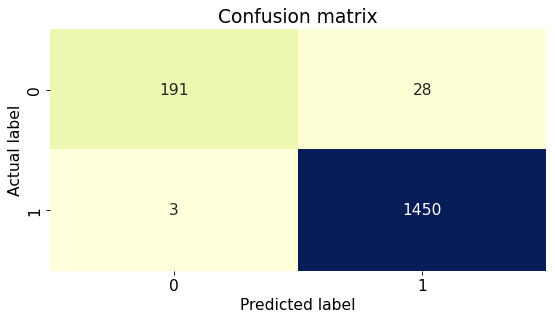

In [146]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=80)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', cbar=False)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [147]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       219
           1       0.98      1.00      0.99      1453

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



Log Confusion matrix on comet

In [148]:
experiment.log_confusion_matrix(y_test, preds, title="Confusion Matrix", row_label="Actual Category",
    column_label="Predicted Category",)

{'web': 'https://www.comet.com/api/asset/download?assetId=7f897fd096144d03b4acce50f3f7cc4d&experimentKey=f9fb44eec56b4dd88df7d13dda90b66e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=7f897fd096144d03b4acce50f3f7cc4d&experimentKey=f9fb44eec56b4dd88df7d13dda90b66e',
 'assetId': '7f897fd096144d03b4acce50f3f7cc4d'}

In [149]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/b-capt/email-spam-classifier/f9fb44eec56b4dd88df7d13dda90b66e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [10]                 : (0.8910256624221802, 1.0)
COMET INFO:     batch_accuracy [390]          : (0.5, 1.0)
COMET INFO:     batch_loss [390]              : (0.00017786049284040928, 0.6932963132858276)
COMET INFO:     epoch_duration [10]           : (1.3128116910011158, 3.9747749050002312)
COMET INFO:     loss [10]                     : (0.00044949084986001253, 0.31850412487983704)
COMET INFO:     val_accuracy [10]             : (0.9635167717933655, 0.9814593195915222)
COMET INFO:     val_loss [10]                 : (0.069393090903759, 0.12005451321601868)
COMET INFO:     validate_batch_accuracy [170] : (0.89999997615814